In [1]:
import numpy as np
from scipy.integrate import quad, quad_vec
from scipy import stats
from quadprog import solve_qp
import matplotlib.pyplot as plt
from patsy import bs
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector, FloatVector
splines = importr("splines")

# Exercise 1

In [2]:
np.random.seed(42)
n = 1000
x = np.linspace(0, 1, n)
def f(x):
    output = np.exp(-x)
    output[x>=0.5] = np.exp(-0.5)
    return output

y = f(x) + np.random.randn(n)*0.05
knots = [i/8 for i in range(1,8)]

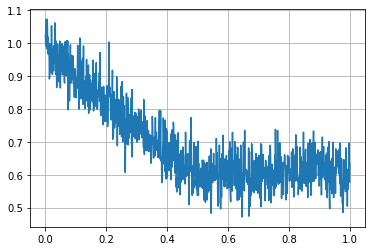

In [3]:
plt.plot(x, y)
plt.grid()
plt.show()

In [4]:
bx = bs(x=x, knots=knots, degree=2, include_intercept=True, lower_bound=0, upper_bound=1)

In [5]:
def splineDesign_derivative_func_Matrix(x, bspline_basis_knots, deg=2):
    bspline_basis_knots = [x[0]]*(deg+1) + bspline_basis_knots + [x[-1]]*(deg+1)
    for i in range(len(bspline_basis_knots) - 3):
        if i == 0:
            basis_derivative_func_matrix = splines.splineDesign(knots=FloatVector(bspline_basis_knots[i:i+4]),
                                                                x=FloatVector(bspline_basis_knots[deg:-deg]),
                                                                derivs=1, ord=deg+1, outer_ok=True)
            basis_derivative_func_matrix = np.array(basis_derivative_func_matrix)
        else:
            temp_matrix = np.array(splines.splineDesign(knots=FloatVector(bspline_basis_knots[i:i+4]),
                                                        x=FloatVector(bspline_basis_knots[deg:-deg]),
                                                        derivs=1, ord=deg+1, outer_ok=True))
            basis_derivative_func_matrix = np.hstack((basis_derivative_func_matrix, temp_matrix))

    return basis_derivative_func_matrix

In [6]:
print(splineDesign_derivative_func_Matrix(x, knots))
print(splineDesign_derivative_func_Matrix(x, knots).shape)

[[-16.  16.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.  -8.   8.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.  -8.   8.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.  -8.   8.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.  -8.   8.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.  -8.   8.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.  -8.   8.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.  -8.   8.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. -16.  16.]]
(9, 10)


In [7]:
G = bx.T @ bx
a = (bx.T @ y.reshape((-1, 1))).flatten()
C = -splineDesign_derivative_func_Matrix(x, knots).T
b = np.zeros((C.shape[1],))
print(G.shape, a.shape, C.shape, b.shape)

(10, 10) (10,) (10, 9) (9,)


In [8]:
quad_solution = solve_qp(G, a, C, b)[0]
print(quad_solution)

[0.99101734 0.93497756 0.82931313 0.74144287 0.62566259 0.60841612
 0.60841612 0.60841612 0.60841612 0.60220908]


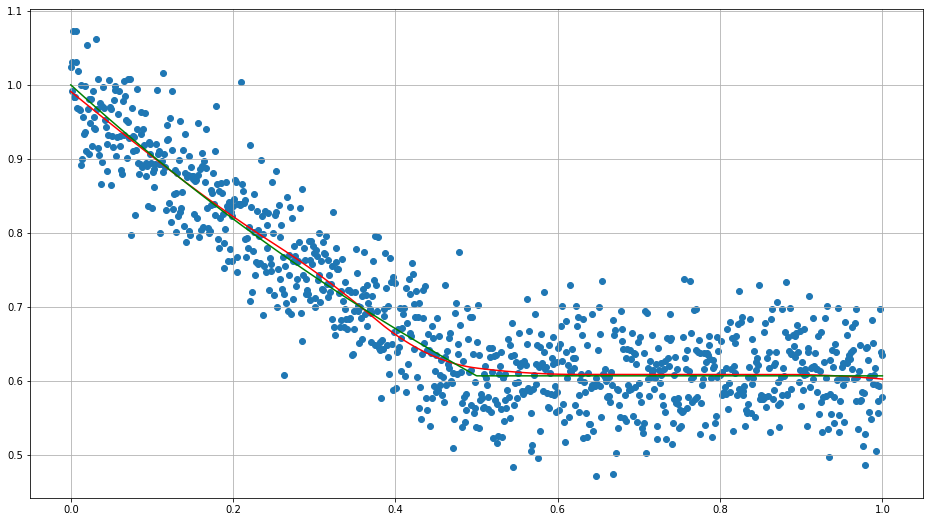

In [9]:
plt.figure(figsize=(16,9))
plt.scatter(x, y)
plt.plot(x, bx@quad_solution, c="r")
plt.plot(x, f(x), c="g")
plt.grid()
plt.show()

In [10]:
def fhat(x):
    bx = bs(x=x, knots=knots, degree=2, include_intercept=True, lower_bound=0, upper_bound=1)
    return bx@quad_solution

def f1(x):
    return np.exp(-x)

def ISE1(w):
    return (fhat(w) - f1(w))**2

def ISE2(w):
    return (fhat(w) - np.exp(-0.5))**2

In [11]:
quad(ISE1, 0, 0.5)

(1.3770583534462692e-05, 1.2996954953850882e-08)

In [12]:
quad(ISE2, 0.5, 1)

(4.979302893471917e-06, 6.00381394953217e-10)

In [13]:
print("ISE: ", quad(ISE1, 0, 0.5)[0]+quad(ISE2, 0.5, 1)[0])

ISE:  1.8749886427934608e-05


# Exercise 2

In [14]:
np.random.seed(10)
n2 = 1000
x2 = np.linspace(-3, 3, n2)
f2 = lambda x: stats.norm.pdf(x)
y2 = f2(x2) + np.random.randn(n2)*0.05
knots2 = list(np.linspace(-3, 3, 7+2))[1:-1]
print(knots2)

[-2.25, -1.5, -0.75, 0.0, 0.75, 1.5, 2.25]


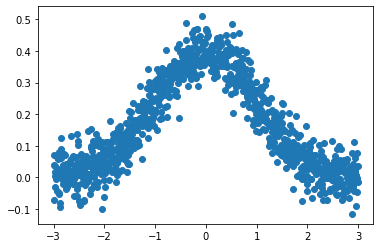

In [15]:
plt.scatter(x2, y2)
plt.show()

In [16]:
bx2 = bs(x=x2, knots=knots2, degree=2, include_intercept=True, lower_bound=-3, upper_bound=3)

In [17]:
splineDesign_derivative_func_Matrix(x2, knots2).shape

(9, 10)

In [18]:
G2 = bx2.T @ bx2
a2 = (bx2.T @ y2.reshape((-1, 1))).flatten()
C2 = splineDesign_derivative_func_Matrix(x2, knots2).T
C2 = C2 @ np.diag([1, 1, 1, 1, 1, -1, -1, -1, -1])
C_copy = C2.copy()
C_copy = np.delete(C_copy, 4, axis=1)
C_meq = C[:, 4].reshape((-1, 1))
C_final = np.hstack((C_meq, C_copy))
b2 = np.zeros((C2.shape[1],))
print(G2.shape, a2.shape, C_final.shape, b2.shape)

(10, 10) (10,) (10, 9) (9,)


In [19]:
quad_solution2 = solve_qp(G2, a2, C_final, b2, meq=1)[0]
print(quad_solution2)

[1.19711631e-02 1.27489216e-02 5.20915603e-02 2.13071148e-01
 3.94372542e-01 3.94372542e-01 2.11803151e-01 3.80717600e-02
 1.12438102e-02 3.68922697e-04]


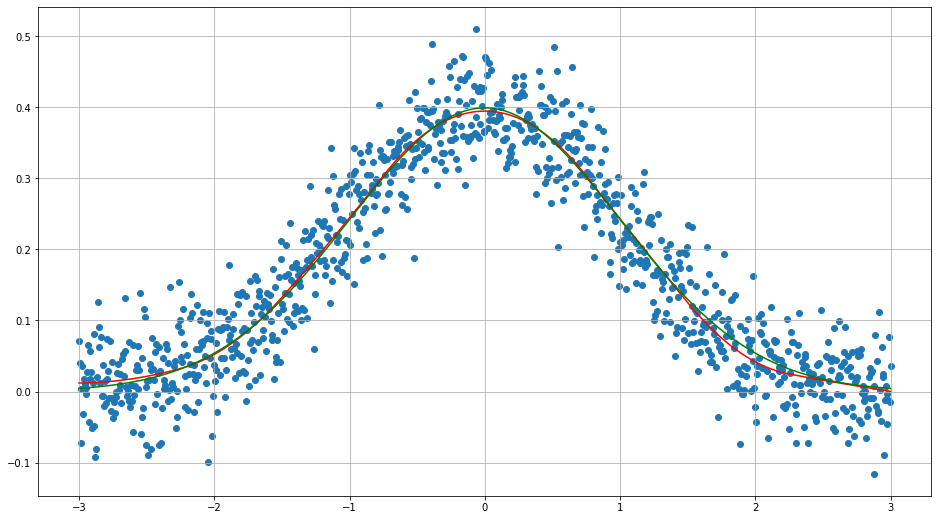

In [20]:
plt.figure(figsize=(16,9))
plt.scatter(x2, y2)
plt.plot(x2, bx2@quad_solution2, c="r")
plt.plot(x2, f2(x2), c="g")
plt.grid()
plt.show()

In [21]:
def fhat2(x):
    bx = bs(x=x, knots=knots2, degree=2, include_intercept=True, lower_bound=-3, upper_bound=3)
    return bx@quad_solution2

def ISE2(w):
    return (fhat2(w) - f2(w))**2

In [22]:
quad(ISE2, 0, 1)

(6.0148120633778765e-06, 6.667737481667445e-20)